## IMU Classifier for Fall Detection

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("imu_labeled_data.csv")
df.head(), df.shape


(                    timestamp     AX     AY     AZ     GX     GY     GZ label
 0  2025-12-10T17:23:46.412824  0.000  0.000  0.000  0.000  0.000  0.000  idle
 1  2025-12-10T17:23:46.440255  0.008 -0.978 -0.072  0.021 -0.976 -0.073  idle
 2  2025-12-10T17:23:46.472158  0.008 -0.978 -0.072  0.021 -0.976 -0.073  idle
 3  2025-12-10T17:23:46.504214  0.008 -0.978 -0.072  0.021 -0.976 -0.073  idle
 4  2025-12-10T17:23:46.535223  0.008 -0.978 -0.072  0.021 -0.976 -0.073  idle,
 (3895, 8))

## Preprocessing and Cleaning

In [17]:
df = df.dropna()

df = df[df["label"].isin(["idle", "run"])].copy()

df["binary_label"] = df["label"].map({
    "idle": "idle",
    "run": "active"
})

le = LabelEncoder()
df["label_enc"] = le.fit_transform(df.binary_label)

# Create sliding-window features for fall detection
WINDOW = 25     # ~0.25 seconds
STEP = 10       # stride
features = []

for start in range(0, len(df) - WINDOW, STEP):
    win = df.iloc[start:start+WINDOW]

    # Magnitudes
    acc_mag = np.sqrt(win.AX**2 + win.AY**2 + win.AZ**2)
    gyro_mag = np.sqrt(win.GX**2 + win.GY**2 + win.GZ**2)

    features.append({
        "ax_mean": win.AX.mean(),
        "ay_mean": win.AY.mean(),
        "az_mean": win.AZ.mean(),
        "acc_peak": acc_mag.max(),
        "acc_std": acc_mag.std(),
        "gyro_peak": gyro_mag.max(),
        "gyro_std": gyro_mag.std(),
        "label": win.binary_label.mode()[0]
    })

feat_df = pd.DataFrame(features)

X = feat_df.drop("label", axis=1).values
y = le.fit_transform(feat_df.label)


## Standardize Features

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Train/Validation Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


## Random Forest Model

In [20]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)
pred = model.predict(X_test)


## Metrics

              precision    recall  f1-score   support

      active       1.00      1.00      1.00        13
        idle       1.00      1.00      1.00        37

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



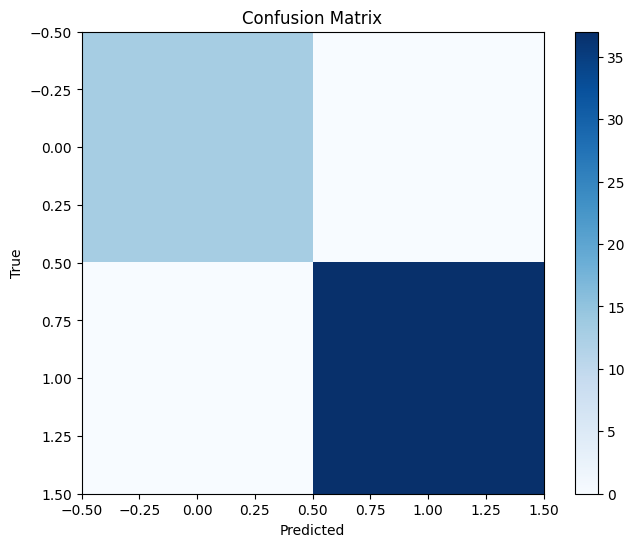

In [21]:
print(classification_report(y_test, pred, target_names=le.classes_))

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()


## Save Model

In [22]:
import joblib

joblib.dump(model, "imu_model.pkl")
joblib.dump(scaler, "imu_scaler.pkl")
joblib.dump(le, "imu_label_encoder.pkl")

print("Saved imu_model.pkl, imu_scaler.pkl, imu_label_encoder.pkl")


Saved imu_model.pkl, imu_scaler.pkl, imu_label_encoder.pkl
